In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Carregar o modelo

In [2]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
# outputs = predictor(im)

[12/09 04:28:41 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


Carregar dataset de car-damage

In [3]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog


# Replace with paths to your dataset
# register_coco_instances("car-damage-v8-train", {}, "datasets/car-damage-v8/train/_annotations.coco.json", "datasets/car-damage-v8/train")
# register_coco_instances("car-damage-v8-test", {}, "datasets/car-damage-v8/valid/_annotations.coco.json", "datasets/car-damage-v8/valid")
register_coco_instances("car-damage-s4-train", {}, "datasets/car-damage-s4/train/_annotations.coco.json", "datasets/car-damage-s4/train")
register_coco_instances("car-damage-s4-test", {}, "datasets/car-damage-s4/test/_annotations.coco.json", "datasets/car-damage-s4/test")

# Verify if the dataset is correctly registered
my_dataset_metadata = MetadataCatalog.get("car-damage-s4-train")
dataset_dicts = DatasetCatalog.get("car-damage-s4-train")



WARNING [12/09 04:28:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/09 04:28:43 d2.data.datasets.coco]: Loaded 644 images in COCO format from datasets/car-damage-s4/train/_annotations.coco.json


Selecionar modelo e treinar dataset de treino

In [4]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")) #
cfg.DATASETS.TRAIN = ("car-damage-s4-train",)
cfg.DATASETS.TEST = ("car-damage-s4-test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.MAX_ITER = 400 #2000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
#cfg.OUTPUT_DIR = "./output"

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[12/09 04:28:46 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (4, 256, 1, 1) 

[12/09 04:28:46 d2.engine.train_loop]: Starting training from iteration 0


/home/ricardofachini/miniconda3/envs/visao-computacional/lib/python3.9/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647380992/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/09 04:28:52 d2.utils.events]:  eta: 0:01:40  iter: 19  total_loss: 3.02  loss_cls: 1.491  loss_box_reg: 0.4415  loss_mask: 0.692  loss_rpn_cls: 0.189  loss_rpn_loc: 0.02377    time: 0.2645  last_time: 0.2485  data_time: 0.0065  last_data_time: 0.0023   lr: 4.8453e-06  max_mem: 1943M
[12/09 04:28:57 d2.utils.events]:  eta: 0:01:37  iter: 39  total_loss: 2.698  loss_cls: 1.402  loss_box_reg: 0.4379  loss_mask: 0.6909  loss_rpn_cls: 0.1063  loss_rpn_loc: 0.01887    time: 0.2712  last_time: 0.2974  data_time: 0.0026  last_data_time: 0.0025   lr: 9.8403e-06  max_mem: 1944M
[12/09 04:29:03 d2.utils.events]:  eta: 0:01:30  iter: 59  total_loss: 2.491  loss_cls: 1.201  loss_box_reg: 0.435  loss_mask: 0.689  loss_rpn_cls: 0.184  loss_rpn_loc: 0.02503    time: 0.2680  last_time: 0.3047  data_time: 0.0025  last_data_time: 0.0024   lr: 1.4835e-05  max_mem: 1945M
[12/09 04:29:08 d2.utils.events]:  eta: 0:01:25  iter: 79  total_loss: 2.396  loss_cls: 0.9743  loss_box_reg: 0.4165  loss_mask: 0.68

Evaluate

In [5]:


from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("car-damage-s4-train", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "car-damage-s4-train")
print(inference_on_dataset(trainer.model, val_loader, evaluator))


[12/09 04:31:03 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [12/09 04:31:03 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [12/09 04:31:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/09 04:31:03 d2.data.datasets.coco]: Loaded 644 images in COCO format from datasets/car-damage-s4/train/_annotations.coco.json
[12/09 04:31:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/09 04:31:03 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/09 04:31:03 d2.data.common]: Serializing 644 elements to byte tensors and concatenating them all ...
[12/09 04:31:03 d2.data.common]: Serialized dat

In [6]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[12/09 04:33:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/home/ricardofachini/miniconda3/envs/visao-computacional/lib/python3.9/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return to

Printar resultados

WARNING [12/09 04:40:11 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/09 04:40:11 d2.data.datasets.coco]: Loaded 644 images in COCO format from datasets/car-damage-s4/train/_annotations.coco.json


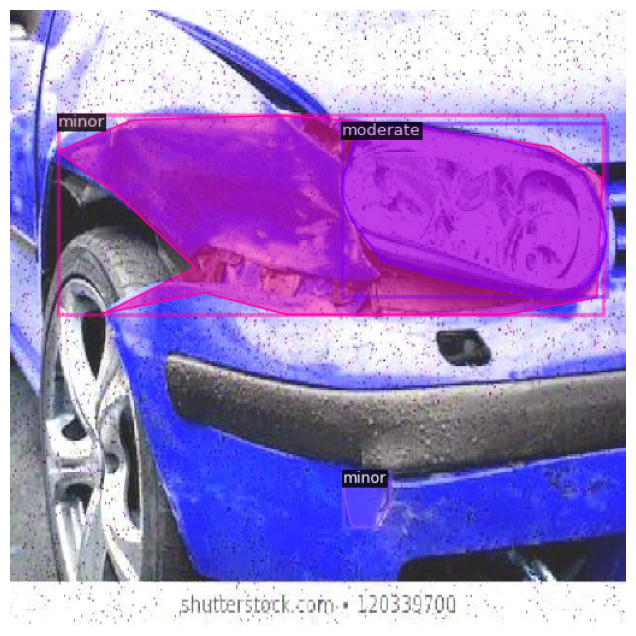

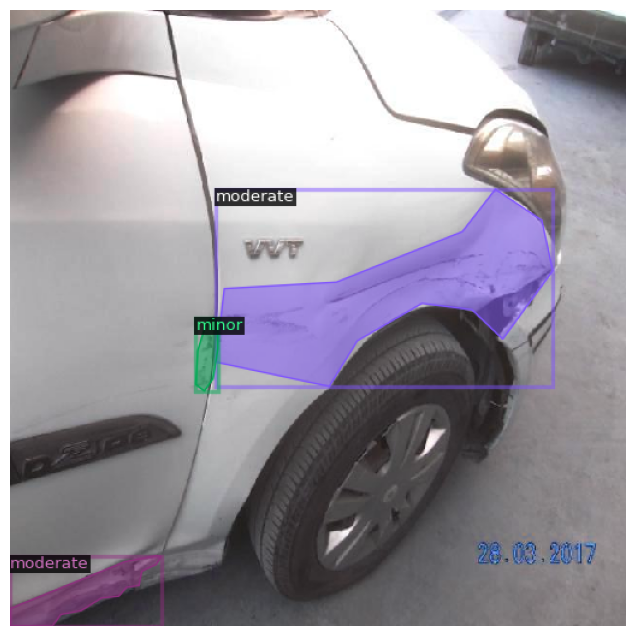

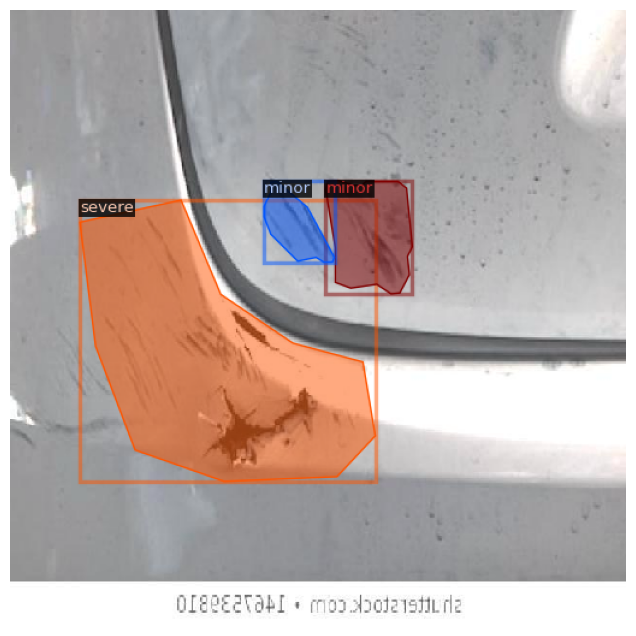

In [9]:
''
from detectron2.utils.visualizer import ColorMode

import random
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog

# Get the dataset metadata and dataset dicts
dataset_dicts = DatasetCatalog.get("car-damage-s4-train")
metadata = MetadataCatalog.get("car-damage-s4-train")

# Plot a few random images from the dataset
for d in random.sample(dataset_dicts, 3):  # Change the number to print more or fewer images
    img = cv2.imread(d["file_name"])

    # Create a visualizer and draw annotations (bounding boxes, etc.)
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8)
    vis = visualizer.draw_dataset_dict(d)

    # Display the image with matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

Testar uma imagem qualquer

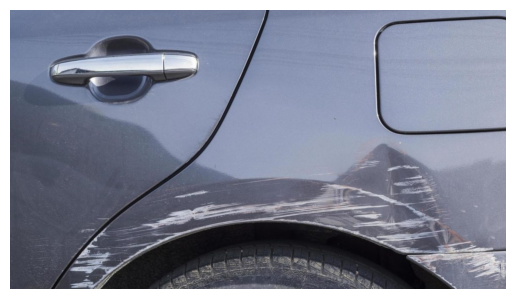

In [55]:
# !wget https://raw.githubusercontent.com/ricardofachini/visao-computacional/refs/heads/main/datasets/car-damage-v8/train/img0363_jpg.rf.262ffe9a33200a95638751b291448bbb.jpg -q -O input.jpg
im_input = cv2.imread("./teste_arranhao.jpg")

# cv2_imshow(im)
img_rgb = cv2.cvtColor(im_input, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(img_rgb)
plt.axis('off')  # Optional: Turn off axis labels
plt.show()

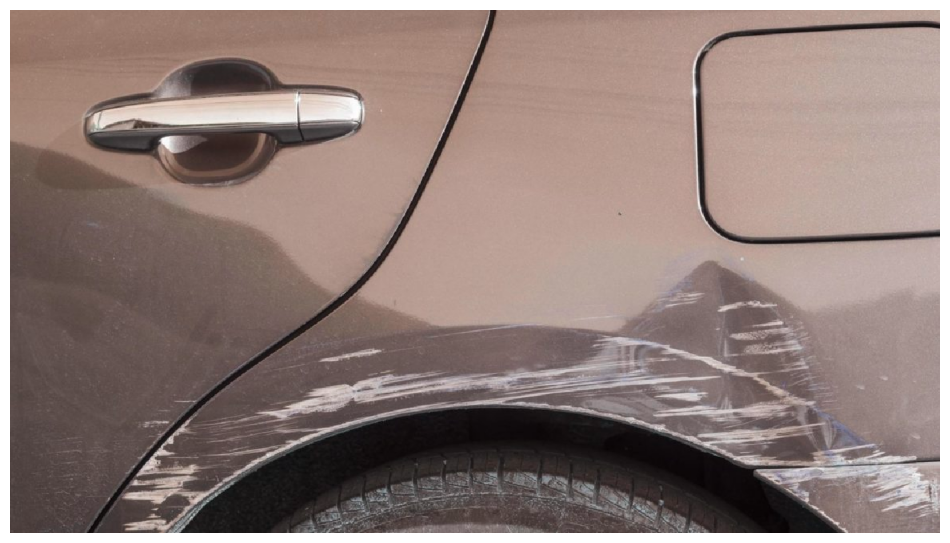

In [56]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im_input[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# cv2_imshow(out.get_image()[:, :, ::-1])
# img_rgb = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)

output_image = out.get_image()[:, :, ::-1]  # Convert BGR back to RGB for display

# Use matplotlib to show the image
plt.figure(figsize=(12, 8))  # Set figure size (optional)
plt.imshow(output_image)
plt.axis('off')  # Hide axes for better visualization
plt.show()